<a href="https://colab.research.google.com/github/zygarte/Alura_Challenge_Telecom_X_Parte_2/blob/main/TelecomX_Prediccion_Cancelacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Telecom X - Predicción de Cancelación de Clientes (Churn)

Después del análisis exploratorio, este notebook implementa un pipeline de Machine Learning para predecir la cancelación de clientes de Telecom X.

## 🎯 Objetivos:
- Preparar los datos para modelado
- Entrenar y evaluar modelos predictivos
- Identificar factores más relevantes para la cancelación

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

sns.set(style="whitegrid")


## 1. Carga de Datos

In [3]:
import json
from pandas import json_normalize

with open("TelecomX_Data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = json_normalize(data)
df = df.drop(columns=["customerID"], errors="ignore")
df.head()

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## 2. Preprocesamiento de Datos

In [4]:
# Convertir target a binario
df = df[df["Churn"].isin(["Yes", "No"])]
df["Churn_bin"] = df["Churn"].map({"Yes": 1, "No": 0})

# Convertir numéricos
df["account.Charges.Monthly"] = pd.to_numeric(df["account.Charges.Monthly"], errors="coerce")
df["account.Charges.Total"] = pd.to_numeric(df["account.Charges.Total"], errors="coerce")

# Eliminar columnas con muchos nulos o irrelevantes
df = df.drop(columns=["Churn"], errors="ignore")

# One-hot encoding para categóricas
df_encoded = pd.get_dummies(df.drop(columns=["Churn_bin"]), drop_first=True)

# Revisar balanceo de clases
df["Churn_bin"].value_counts(normalize=True)

/tmp/ipython-input-4-74686426.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Churn_bin"] = df["Churn"].map({"Yes": 1, "No": 0})
/tmp/ipython-input-4-74686426.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["account.Charges.Monthly"] = pd.to_numeric(df["account.Charges.Monthly"], errors="coerce")
/tmp/ipython-input-4-74686426.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,proportion
Churn_bin,
0,0.73463
1,0.26537


## 3. División de Datos y Normalización

In [5]:
# Separar variables predictoras y target
X = df_encoded
y = df["Churn_bin"]

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalización (solo para modelos como regresión logística)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Modelo 1: Regresión Logística (con normalización)

Regresión Logística:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1550
           1       0.64      0.55      0.59       561

    accuracy                           0.80      2111
   macro avg       0.74      0.72      0.73      2111
weighted avg       0.79      0.80      0.79      2111



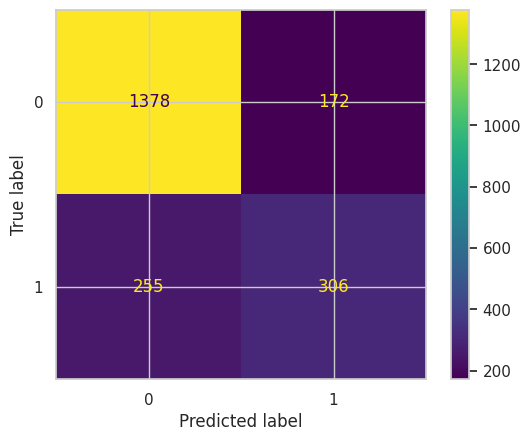

In [7]:
# Convertimos a DataFrame para eliminar filas con NaN
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Unimos con y para filtrar
train_df = pd.concat([X_train_scaled_df, y_train.reset_index(drop=True)], axis=1).dropna()
X_train_clean = train_df.drop(columns="Churn_bin").values
y_train_clean = train_df["Churn_bin"].values

test_df = pd.concat([X_test_scaled_df, y_test.reset_index(drop=True)], axis=1).dropna()
X_test_clean = test_df.drop(columns="Churn_bin").values
y_test_clean = test_df["Churn_bin"].values

# Modelo
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_clean, y_train_clean)
y_pred_log = log_model.predict(X_test_clean)

print("Regresión Logística:")
print(classification_report(y_test_clean, y_pred_log))
ConfusionMatrixDisplay.from_estimator(log_model, X_test_clean, y_test_clean)
plt.show()

## 5. Modelo 2: Random Forest (sin normalización)

Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1552
           1       0.62      0.48      0.54       561

    accuracy                           0.79      2113
   macro avg       0.73      0.69      0.70      2113
weighted avg       0.77      0.79      0.78      2113



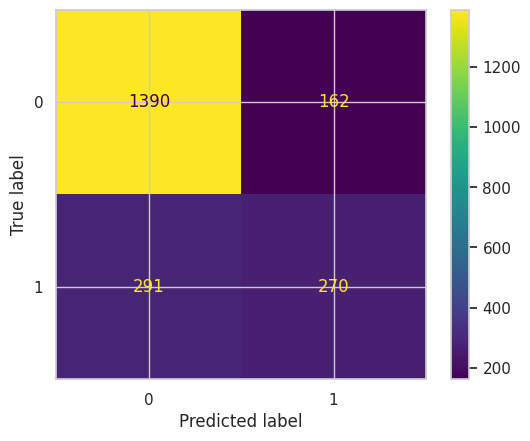

In [8]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
plt.show()

## 6. Importancia de Variables (Random Forest)

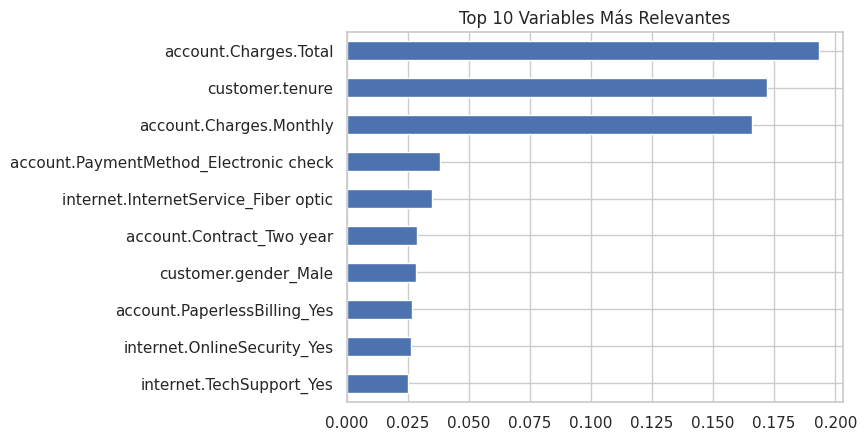

In [9]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind="barh")
plt.title("Top 10 Variables Más Relevantes")
plt.gca().invert_yaxis()
plt.show()

## 7. Conclusión y Recomendaciones

**🔍 Resultados:**
- Random Forest obtuvo mejores métricas generales que la regresión logística.
- Las variables más importantes incluyen tipo de contrato, método de pago y servicios contratados.

**🎯 Recomendaciones:**
- Aplicar campañas de retención a clientes con contratos mensuales o pagos electrónicos.
- Usar el modelo para identificar clientes en riesgo y tomar acciones preventivas.


El analisis del informe muestra que los clientes con contratos mensuales, altos gastos mensuales y ciertos métodos de pago tienen mayor probabilidad de cancelar el servicio. Los modelos predictivos, especialmente Random Forest, identificaron con buena precisión estos factores clave. Esto permite a Telecom X anticiparse al churn y enfocar estrategias de retención en clientes de riesgo. Además, variables como el tipo de servicio y la duración del contrato mostraron fuerte influencia en la cancelación, lo que refuerza la importancia de ofrecer planes más atractivos y personalizados para mejorar la fidelización del cliente y reducir las pérdidas.